In [34]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

# Optimization with 3 stations

## Load forcing


In [35]:
latitude_bats = 31.6
longitude_bats = -64.2

Load forcing.


In [36]:
time_start, time_end = "2000-01-01", "2022-01-01"

data = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Bats_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
data["npp"].attrs = {"units": "mg / day / m2"}
data.load()

<xarray.Dataset> Size: 1MB
Dimensions:              (latitude: 1, longitude: 1, time: 8037, depth: 3)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float64 8B 31.6
  * longitude            (longitude) float64 8B -64.2
  * time                 (time) datetime64[ns] 64kB 2000-01-01 ... 2022-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 193kB 20....
    U                    (latitude, longitude, time, depth) float64 193kB -0....
    V                    (latitude, longitude, time, depth) float64 193kB -0....
    mnkc_epi             (latitude, longitude, time) float64 64kB 0.481 ... 1...
    mnkc_hmlmeso         (latitude, longitude, time) float64 64kB 0.5 ... 1.108
    mnkc_lmeso           (latitude, longitude, time) float64 64kB 0.7443 ... ...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 64kB 0.4439 ... ...
    mnkc_umeso           (latitude, longitude, time) float64 64kB 0.2323 ... ...
    npp                  (latitude, longitude, time) float64 64kB 328.2 ... 2...
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 193kB 115...
    zeu                  (latitude, longitude, time) float64 64kB 76.53 ... 7...
    zooc                 (latitude, longitude, time) float64 64kB 0.3359 ... ...

Load observations.

First I multiply the observations by the epipelagic layer depth to have a biomass in m2 rather than m3.


In [37]:
def update_layer(data: xr.DataArray, epipelagic_size):
    """Multiply biomass density of observation by the 150m which is the average epipelagic layer depth."""
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = data.pelagic_layer_depth.sel(depth=1).drop_vars("depth") * pint.application_registry("meter")

obs_bats = xr.open_dataset("../../1_data_processing/1_1_Forcing/products/Bats_climato.zarr", engine="zarr")
obs_bats = update_layer(obs_bats, epipelagic_size.sel(latitude=latitude_bats, longitude=longitude_bats))
obs_bats["day"] = obs_bats["day"] + obs_bats["day_trend"]
obs_bats["night"] = obs_bats["night"] + obs_bats["night_trend"]
obs_bats = Observation(obs_bats)

observations = [obs_bats]

Create structure for SeapoPym simulation.


In [38]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=data["npp"], resolution=1 / 12, timestep=1),
)

2024-12-18 14:23:27,786 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [39]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 0.2),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
    ),
]

In [40]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [41]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=400,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [42]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [43]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54105 instead



And watch the magic on the Dask dashboard :


In [14]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52330/status,
Dashboard: http://127.0.0.1:52330/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52331,Workers: 4
Dashboard: http://127.0.0.1:52330/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52342,Total threads: 2
Dashboard: http://127.0.0.1:52346/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52334,


## Run the optimization


In [15]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,350.537549,792.776584,0.108444,6177.834028,281,0.000000
1,147.477603,513.984697,0.099660,5500.166755,365,0.200000
2,13.903258,49.658237,0.099660,540.616970,395,0.210127
3,1.704591,6.685669,0.095690,114.059046,395,0.139241
4,1.494740,13.701943,0.095690,263.321054,396,0.146465
5,0.433532,1.944189,0.095686,32.634349,400,0.125000
6,0.308084,0.729962,0.095686,7.800000,399,0.162907
7,0.401324,1.297503,0.099304,14.459911,400,0.140000
8,0.328996,1.108141,0.099304,15.576638,400,0.212500


## Plot the results


In [16]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,350.537549,792.776584,0.108444,6177.834028,281,0.000000
1,147.477603,513.984697,0.099660,5500.166755,365,0.200000
2,13.903258,49.658237,0.099660,540.616970,395,0.210127
3,1.704591,6.685669,0.095690,114.059046,395,0.139241
4,1.494740,13.701943,0.095690,263.321054,396,0.146465
5,0.433532,1.944189,0.095686,32.634349,400,0.125000
6,0.308084,0.729962,0.095686,7.800000,399,0.162907
7,0.401324,1.297503,0.099304,14.459911,400,0.140000
8,0.328996,1.108141,0.099304,15.576638,400,0.212500


In [17]:
viewer.logbook

D1N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.611540   
                               1                          0.632530   
                               2                          0.138595   
                               3                          0.109791   
                               4                          0.344146   
...                                                            ...   
10         True                381                        0.612684   
                               392                        0.579694   
                               393                        0.635894   
                               398                        0.579694   
                               399                        0.579694   

                                           D1N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                    234.202058   
                               1                    252.234254   
                               2                    315.941668   
                               3                    323.768812   
                               4                    306.166536   
...                                                        ...   
10         True                381                    6.039033   
                               392                    6.039033   
                               393                    3.386625   
                               398                    6.039033   
                               399                   17.183930   

                                           D1N1_inv_lambda_rate  \
generation previous_generation individual                         
0          False               0                       0.084949   
                               1                       0.174426   
                               2                       0.022613   
                               3                       0.020703   
                               4                       0.177180   
...                                                         ...   
10         True                381                     0.168842   
                               392                     0.190370   
                               393                     0.149416   
                               398                     0.184576   
                               399                     0.190370   

                                           D2N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.173950   
                               1                          0.465827   
                               2                          0.533972   
                               3                          0.163471   
                               4                          0.096445   
...                                                            ...   
10         True                381                        0.081693   
                               392                        0.054244   
                               393                        0.115221   
                               398                        0.081207   
                               399                        0.061677   

                                           D2N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                    494.723692   
                               1                     87.649359   
                               2                    495.909413   
                               3                    298.534494   
                               4                    285.052188   
...                         

In [18]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_inv_lambda_max  \
generation individual                                                 
5          209                        0.059266            69.313092   
3          29                         0.059266            69.313092   
9          238                        0.579694             6.039033   
           180                        0.579694             6.039033   
5          259                        0.579694             6.039033   
...                                        ...                  ...   
0          347                        0.476347           387.424558   
           322                        0.466180           492.730997   
1          205                        0.637878           329.962722   
           372                        0.693309           485.990279   
0          77                         0.375041           361.477518   

                       D1N1_inv_lambda_rate  D2N1_energy_coefficient  \
generation individual                                                  
5          209                     0.077493                 0.154311   
3          29                      0.077493                 0.154311   
9          238                     0.190370                 0.054244   
           180                     0.161232                 0.054244   
5          259                     0.161232                 0.054244   
...                                     ...                      ...   
0          347                     0.005757                 0.277868   
           322                     0.038065                 0.497621   
1          205                     0.009115                 0.269996   
           372                     0.024878                 0.198912   
0          77                      0.012861                 0.506160   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate      fitness  
generation individual                                                          
5          209                   25.118847              0.119190     0.095686  
3          29                    25.034633              0.119190     0.095690  
9          238                  477.765879              0.172217     0.098911  
           180                  477.765879              0.172217     0.099304  
5          259                  477.765879              0.172217     0.099304  
...                                    ...                   ...          ...  
0          347                  254.481499              0.063518  4102.554567  
           322                  336.329918              0.012603  4467.496259  
1          205                  414.854228              0.064415  4976.283893  
           372                  124.538376              0.097039  5500.166755  
0          77                   497.000030              0.016926  6177.834028  

[3564 rows x 7 columns]

In [19]:
viewer.fitness_evolution()

In [20]:
viewer.box_plot(3)

In [21]:
fig = viewer.parallel_coordinates(500, unselected_opacity=0)
fig.update_layout(width=1000, height=700)

# Generate plots at each station


In [60]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from seapopym_optimization import wrapper

In [23]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {best_individual}")

Best individual: [[ 1.00000000e+00  1.00000000e+00  5.92663412e-02  1.03800000e+01
  -1.10000000e-01  6.93130923e+01  7.74925024e-02]
 [ 2.00000000e+00  1.00000000e+00  1.54310841e-01  1.03800000e+01
  -1.10000000e-01  2.51188468e+01  1.19190043e-01]]


In [61]:
best_individual = [
    [1.00000000e00, 1.00000000e00, 5.92663412e-02, 1.03800000e01, -1.10000000e-01, 6.93130923e01, 7.74925024e-02],
    [2.00000000e00, 1.00000000e00, 1.54310841e-01, 1.03800000e01, -1.10000000e-01, 2.51188468e01, 1.19190043e-01],
]

In [62]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        best_individual,
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

In [63]:
def plot_comparison_to_station(
    obs_1: pd.Series,
    model_1: pd.Series,
    obs_2: pd.Series,
    model_2: pd.Series,
    station_name: str,
    subplot_titles: tuple = ("D1N1", "D2N1"),
    *,
    obs_as_marker: bool = False,
):
    fig = make_subplots(
        rows=2,
        cols=1,
        subplot_titles=subplot_titles,
        shared_xaxes=True,
        x_title="Time",
        y_title="Biomass (g/m2)",
        vertical_spacing=0.1,
    )

    if obs_as_marker:
        additional_param = {"mode": "markers", "marker": {"symbol": "cross", "size": 4}}
    else:
        additional_param = {"mode": "lines"}

    fig.add_trace(
        go.Scatter(x=obs_1.index, y=obs_1, name=f"Observation {subplot_titles[0]}", **additional_param), row=1, col=1
    )
    fig.add_trace(go.Scatter(x=model_1.index, y=model_1, name=f"Model {subplot_titles[0]}"), row=1, col=1)

    fig.add_trace(
        go.Scatter(x=obs_2.index, y=obs_2, name=f"Observation {subplot_titles[1]}", **additional_param), row=2, col=1
    )
    fig.add_trace(go.Scatter(x=model_2.index, y=model_2, name=f"Model {subplot_titles[1]}"), row=2, col=1)

    fig.update_layout(title=f"{station_name} Station", width=1000, height=700)
    return fig


def clean_series(series):
    return series.pint.quantify().pint.to("g/m2").pint.dequantify().to_series().dropna()

## BATS


In [64]:
biomass_bats_plot_d1n1 = clean_series(
    biomass_print.sel(latitude=latitude_bats, longitude=longitude_bats, functional_group=0)
)
biomass_bats_plot_d2n1 = clean_series(
    biomass_print.sel(latitude=latitude_bats, longitude=longitude_bats, functional_group=1)
)

obs_bats_plot_d1n1 = clean_series(obs_bats.observation.day.isel(latitude=0, longitude=0, layer=0))

obs_bats_plot_d2n1 = clean_series(
    (obs_bats.observation.night.pint.quantify() - obs_bats.observation.day.pint.quantify()).isel(
        latitude=0, longitude=0, layer=0
    )
)


plot_comparison_to_station(
    obs_bats_plot_d1n1, biomass_bats_plot_d1n1, obs_bats_plot_d2n1, biomass_bats_plot_d2n1, "BATS"
)

In [65]:
biomass_bats_plot_d1n1 = clean_series(
    biomass_print.sel(latitude=latitude_bats, longitude=longitude_bats, functional_group=0)
)
biomass_bats_plot_d2n1 = clean_series(
    biomass_print.sel(latitude=latitude_bats, longitude=longitude_bats, functional_group=1)
)

obs_bats_plot_d1n1 = clean_series(obs_bats.observation.day.isel(latitude=0, longitude=0, layer=0))

obs_bats_plot_d2n1 = clean_series(
    (obs_bats.observation.night.pint.quantify() - obs_bats.observation.day.pint.quantify()).isel(
        latitude=0, longitude=0, layer=0
    )
)


plot_comparison_to_station(
    obs_bats_plot_d1n1.resample("ME").mean(),
    biomass_bats_plot_d1n1.resample("ME").mean(),
    obs_bats_plot_d2n1.resample("ME").mean(),
    biomass_bats_plot_d2n1.resample("ME").mean(),
    "Monthly : BATS",
)

## Taylor diagram


correlation [-0.35259047719967634, 0.012665999040407197]
norm STD [1.3168051755227987, 0.8610090045210843]
bias [-0.578904341348126, -0.8251424858264536]
NRMSE [1.913782067194905, 1.3113067632771123]
name ['BATS D1N1', 'BATS D2N1']


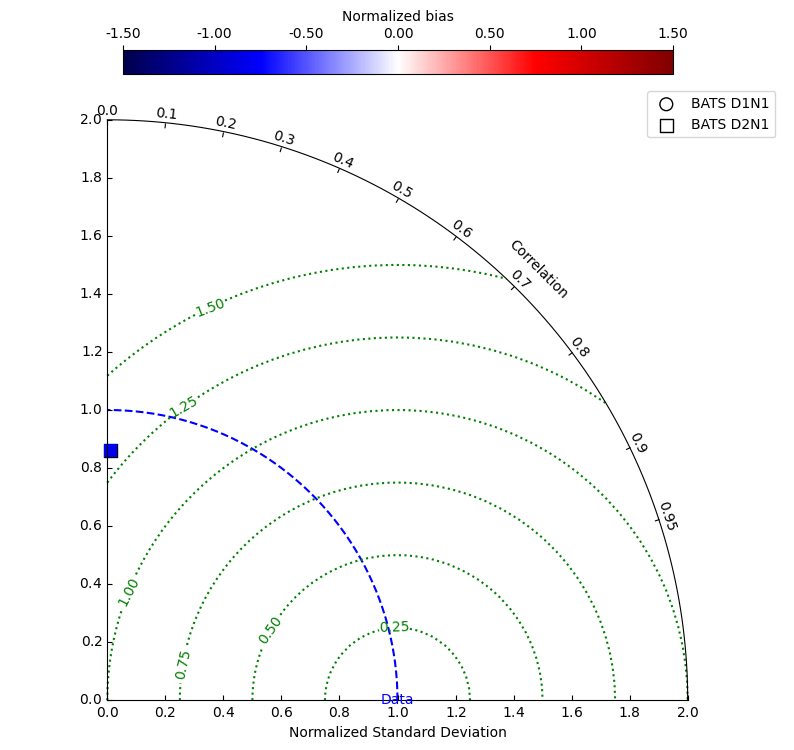

In [66]:
diagram = ModTaylorDiagram()

all_model = [
    biomass_bats_plot_d1n1,
    biomass_bats_plot_d2n1,
]
all_obs = [
    obs_bats_plot_d1n1,
    obs_bats_plot_d2n1,
]

all_names = ["BATS D1N1", "BATS D2N1"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)

diagram.plot()